# Mode Cleaner design notebook
Calculate the transmission of the mode cleaner (MC), find the ideal parameters of the cavity (Length, Finesse, RoC) and calculate the losses and characteristics of the circulating beam. The geometric & optical length are defined as in the thesis of Eleonora Polini (p209).

In [1]:
# import the required libraries

import matplotlib.pyplot as plt
import numpy as np
import MC_design_functions as MCdf
import sys
import math
plt.style.use('ggplot')

c = 2.99792e8 # Speed of light
lambda_ = 1064e-9 # Carrier wavelength (m)
idxn = 1.44963 # Index of the cavity
SB_limit = 0.90  # SBs transmissions limit
fm = [6.270777e6, 6.270777e6 * 9]  # List of the SBs frequency
P_HOMs = [np.ones(10), np.full(10, 2), np.full(10, 2)]  # Input power of carrier & SBs HOMs
f = c / lambda_ # Carrier frequency (Hz)
TEM_limit = 0.01 # Sidebands & HOMs transmissions limits
nm_max = 10 # Number of HOMs to consider
k=2*np.pi*f/c

## General tests

Plot a two-mirror Fabry–Perot cavity reflection transfer function and a PDH readout signal.

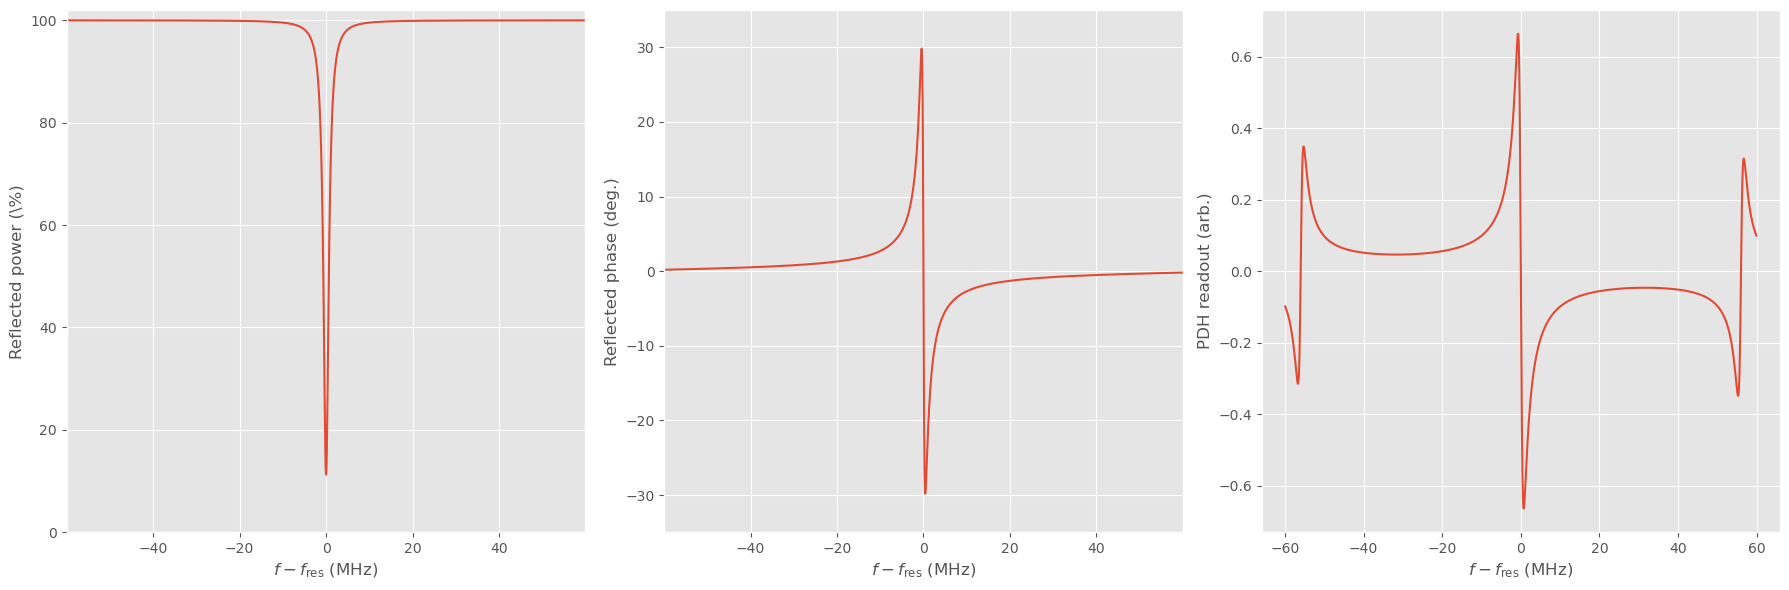

In [2]:
# Call the function with the desired parameters
L = 1.  # length of the optical cavity
r1 = .99  # input mirror reflectivity
r2 = .98  # end mirror reflectivity

f, R, pdh, fsr = MCdf.PDH(L, 56e6,r1,r2)

# Set up subplots and plot the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Reflected power
axes[0].plot(f/1e6, 100*np.abs(R)**2)
axes[0].axis([-.4*fsr/1e6, .4*fsr/1e6, 0, 102])
axes[0].set_ylabel('Reflected power (\%)')
axes[0].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot Reflected phase
axes[1].plot(f/1e6, 180*np.angle(R)/np.pi)
axes[1].axis([-.4*fsr/1e6, .4*fsr/1e6, -35, 35])
axes[1].set_ylabel('Reflected phase (deg.)')
axes[1].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot PDH readout
axes[2].plot(f/1e6, np.imag(pdh))
axes[2].set_ylabel('PDH readout (arb.)')
axes[2].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.show()

Determine the parameters intervals of a mode cleaner cavity (cf VIR-NOT-071A-08).

In [3]:
# Constants
Lopt_lim, F_lim, RoC_lim = [2*idxn*1.5e-2, 2*idxn*30e-2], [5, 500], [0,0] # Parameters limits
FLopt_lim=[0,0]; RLgeo_lim=[0,0]

print("-----Parameters intervals-----")
# Losses limitations
losses_max=1/100; P=30/1000000 # P being the loss per face
if np.pi*losses_max/(4*P)<F_lim[1]: F_lim[1]=np.pi*losses_max/(4*P)
print(round(F_lim[0],4),"<F<",round(F_lim[1],4))

# Sidebands transmission
FLopt_lim[1]=np.sqrt(((1-SB_limit)*c**2)/(16*SB_limit*fm[1]**2))
Lopt_lim[1]=FLopt_lim[1]/F_lim[0]
print(round(Lopt_lim[0]*1e2,4),"<Lopt (cm)<",round(Lopt_lim[1]*1e2,4)) # Lopt being the optical length of a one way trip

# Filtering of higher modes
RLgeo_lim[1]=TEM_limit*(2*FLopt_lim[1]/(idxn*np.pi))**2
RoC_lim[0]=RLgeo_lim[1]/(0.5*Lopt_lim[1]/idxn); RoC_lim[1]=RLgeo_lim[1]/(0.5*Lopt_lim[0]/idxn) # Since Lopt=2*Lgeo*n
print(round(RoC_lim[0]*1e2,4),"<RoC (cm)<",round(RoC_lim[1]*1e2,4))

-----Parameters intervals-----
5 <F< 261.7994
4.3489 <Lopt (cm)< 8.8533
1.2376 <RoC (cm)< 2.5194


The length & RoC needs to be smaller than the one used in the OMC (RoC of 780mm, from VIR-0319A-12). Then we can plot the astigmatism losses.

OMC astigmatism losses (ppm)= 48.32284948698759


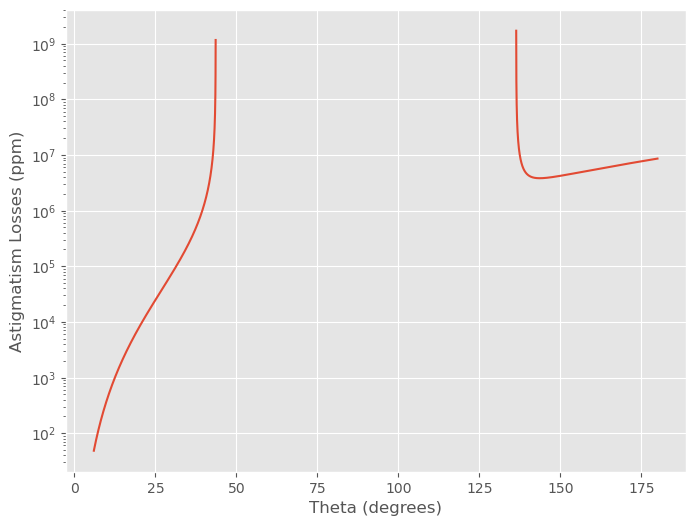

In [4]:
# Astigmatism losses

# Define the parameters for the plot
RoC = 780e-3
Lgeo = MCdf.Lgeo_cavity(0.061315, 0.026068)
Lopt= 2*idxn*Lgeo
theta_min = np.deg2rad(6)
theta_max = np.pi
num_points = 10000

# Create an array of angles (theta) in radians
theta_values = np.linspace(theta_min, theta_max, num_points)

# Calculate astigmatism_losses for each theta value and convert to ppm
astigmatism_losses_values = [MCdf.astigmatism_losses(theta, RoC, Lgeo) * 1e6 for theta in theta_values]

print("OMC astigmatism losses (ppm)=", MCdf.astigmatism_losses(np.deg2rad(6), RoC, Lgeo)*1e6)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(np.rad2deg(theta_values), astigmatism_losses_values)
plt.xlabel("Theta (degrees)")
plt.ylabel("Astigmatism Losses (ppm)")
plt.yscale('log')
#plt.title("Astigmatism Losses as a Function of Theta")
plt.show()

The formula used is a valid approximation for small angles. With an angle of 6° we get 48ppm, which is the losses for the OMC (VIR-0319A-12).

## HOMs transmissions

### Heatmap of the HOMs transmissions

We specify a limit on the width of the cavity (15mm).

Progress: 100.00%
Calculation done.


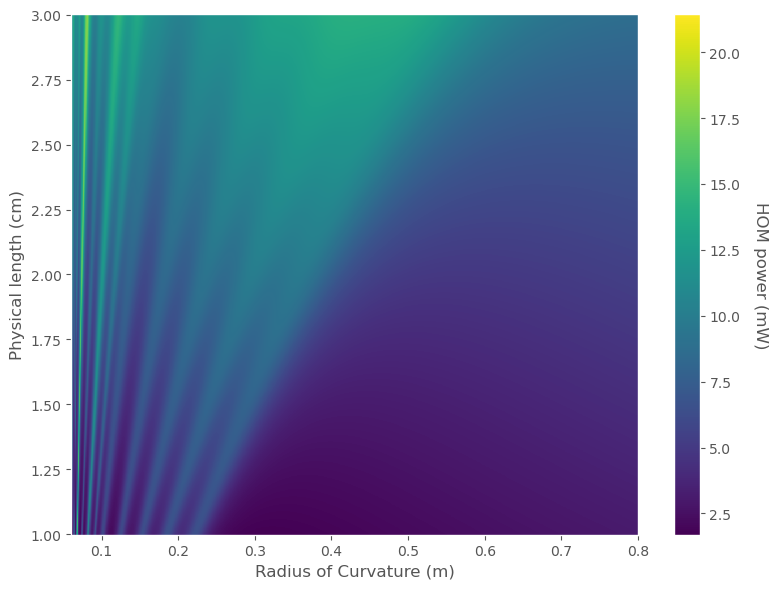

In [5]:
# Heatmap of the HOMs transmissions

# Create a grid of physical lengths
Lphys_vect = np.linspace(1e-2, 3e-2, 1001) # cm

# Initialize T_HOMs matrices for carrier and SBs
T_HOMs_mat_car = np.zeros((len(Lphys_vect), 1001))
T_HOMs_mat_SB = np.zeros((len(Lphys_vect), 1001))

# Loop over geometric lengths and calculate T_HOMs
for j, Lphys in enumerate(Lphys_vect):
    Lgeo = MCdf.Lgeo_cavity(Lphys, 15e-3)  # Geometric length of the cavity
    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Lopt=2*idxn*Lgeo
    Fomc = FLopt_max / Lopt
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, 0.8, fm, P_HOMs, 1001)
    T_HOMs_mat_car[j, :] = T_HOMs_vect_car
    T_HOMs_mat_SB[j, :] = T_HOMs_vect_SB[0]+T_HOMs_vect_SB[1] # Transpose the result to match dimensions
    
    # Print percentage of completion
    sys.stdout.write("\rProgress: {0:.2f}%".format((j+1)/len(Lphys_vect)*100))
    sys.stdout.flush()

# After the loop
print("\nCalculation done.")

# Plot the heatmaps
plt.figure(figsize=(8, 6))

c1 = plt.pcolormesh(rho_vect, Lphys_vect*100, T_HOMs_mat_car+T_HOMs_mat_SB, cmap='viridis')
plt.xlabel('Radius of Curvature (m)')
plt.ylabel('Physical length (cm)')
#plt.title('HOM power vs cavity RoC & geometric length with adapted finesse')
colorbar=plt.colorbar(c1)
colorbar.set_label('HOM power (mW)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

Zoomed on feasable and interesting values.

Progress: 100.00%
Calculation done.


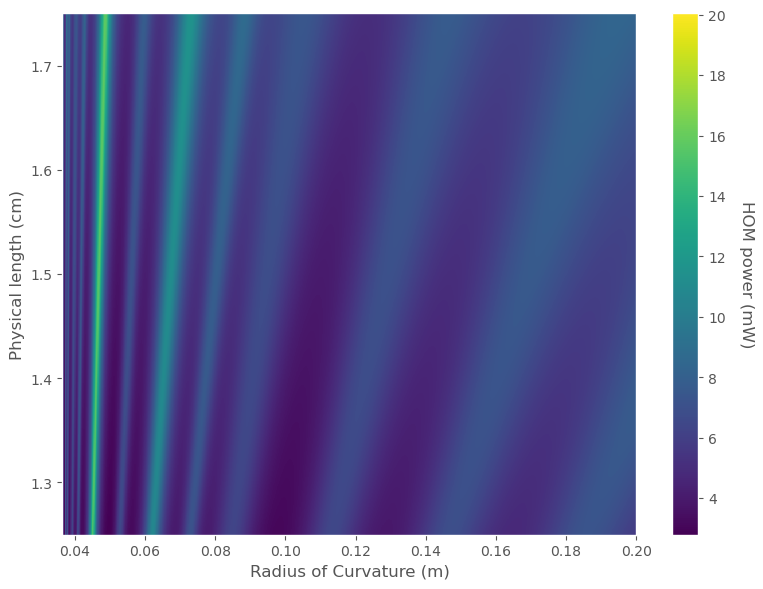

In [6]:
# Heatmap of the HOMs transmissions

# Create a grid of physical lengths
Lphys_vect = np.linspace(1.25e-2, 1.75e-2, 1001) # cm

# Initialize T_HOMs matrices for carrier and SBs
T_HOMs_mat_car = np.zeros((len(Lphys_vect), 1001))
T_HOMs_mat_SB = np.zeros((len(Lphys_vect), 1001))

# Loop over geometric lengths and calculate T_HOMs
for j, Lphys in enumerate(Lphys_vect):
    Lgeo = MCdf.Lgeo_cavity(Lphys, 15e-3)  # Geometric length of the cavity
    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Lopt=2*idxn*Lgeo
    Fomc = FLopt_max / Lopt
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, 0.2, fm, P_HOMs, 1001)
    T_HOMs_mat_car[j, :] = T_HOMs_vect_car
    T_HOMs_mat_SB[j, :] = T_HOMs_vect_SB[0]+T_HOMs_vect_SB[1] # Transpose the result to match dimensions
    
    # Print percentage of completion
    sys.stdout.write("\rProgress: {0:.2f}%".format((j+1)/len(Lphys_vect)*100))
    sys.stdout.flush()

# After the loop
print("\nCalculation done.")

# Plot the heatmaps
plt.figure(figsize=(8, 6))

c1 = plt.pcolormesh(rho_vect, Lphys_vect*100, T_HOMs_mat_car+T_HOMs_mat_SB, cmap='viridis')
plt.xlabel('Radius of Curvature (m)')
plt.ylabel('Physical length (cm)')
#plt.title('HOM power vs cavity RoC & geometric length with adapted finesse')
colorbar=plt.colorbar(c1)
colorbar.set_label('HOM power (mW)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

Find the parameters that filters as much as possible the HoMs.

In [7]:
# Compute the HOM power matrix
T_HOMs = T_HOMs_mat_car + T_HOMs_mat_SB

# Find the index of the minimum value in the HOM power matrix
min_index = np.unravel_index(np.argmin(T_HOMs, axis=None), T_HOMs.shape)

# Get the corresponding Lgeo and RoC values
Lphys_min = Lphys_vect[min_index[0]]
RoC_min = rho_vect[min_index[1]]

# Get the corresponding HOM power value
min_HOM_power = T_HOMs[min_index]

print(f"Minimum HOM power in the meshgrid is {min_HOM_power} W at geometric length: {Lphys_min*1e2} cm and RoC: {RoC_min*1e2} cm")


Minimum HOM power in the meshgrid is 2.788080835260131 W at geometric length: 1.25 cm and RoC: 4.9616278143487 cm


The ideal feasable length seems to be around 1.5cm, with a RoC of around 10cm.

### HOMs transmissions with fixed lengths

In [8]:
# Input parameters
length_divisors = [2, 4, 6, 8]
results = []

for divisor in length_divisors:
    Lgeo = MCdf.Lgeo_cavity(0.061315/divisor, 0.026068)  #length of the OMC=0.061315m, width=0.026068m
    Lopt = 2*idxn*Lgeo  
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Fomc = FLopt_max / Lopt
    RoC_max = 1.6/divisor
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HOMs, 10001)
    T_HOMs_vect_sum = T_HOMs_vect_car + T_HOMs_vect_SB[0] + T_HOMs_vect_SB[1]
    r = rho_vect[np.argmin(T_HOMs_vect_sum)]
    waist = MCdf.waist_size(Lgeo, r, lambda_)
    max_pwr = MCdf.circ_power(1.0, waist)
    print(f"Length (cm): Geometric (divisor={divisor})= ", Lgeo * 10 ** 2, ", physical= ", (0.061315/divisor)*1e2)
    print("Finesse: ", Fomc)
    print("Ideal RoC (m): ", r)
    print("Waist size (μm):", waist*1e6)
    print("Circ power (MW/m²):", max_pwr/1e6) # Supposing an input of 1W
    print()
    results.append((rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB, T_HOMs_vect_sum, Lgeo))



Length (cm): Geometric (divisor=2)=  3.1985336251765397 , physical=  3.06575
Finesse:  4.773499074834663
Ideal RoC (m):  0.8
Waist size (μm): 707.3529599561481
Circ power (MW/m²): 1.9986081294914484

Length (cm): Geometric (divisor=4)=  1.7724888562469114 , physical=  1.532875
Finesse:  8.613987753320396
Ideal RoC (m):  0.4
Waist size (μm): 511.9881219919733
Circ power (MW/m²): 3.81487426789672

Length (cm): Geometric (divisor=6)=  1.3390835101048029 , physical=  1.0219166666666666
Finesse:  11.401975444692626
Ideal RoC (m):  0.04045511500057658
Waist size (μm): 210.06130834165867
Circ power (MW/m²): 22.662502644604814

Length (cm): Geometric (divisor=8)=  1.1392409059925097 , physical=  0.7664375
Finesse:  13.402079595540926
Ideal RoC (m):  0.03442785556937604
Waist size (μm): 193.79614392847986
Circ power (MW/m²): 26.626233558354837



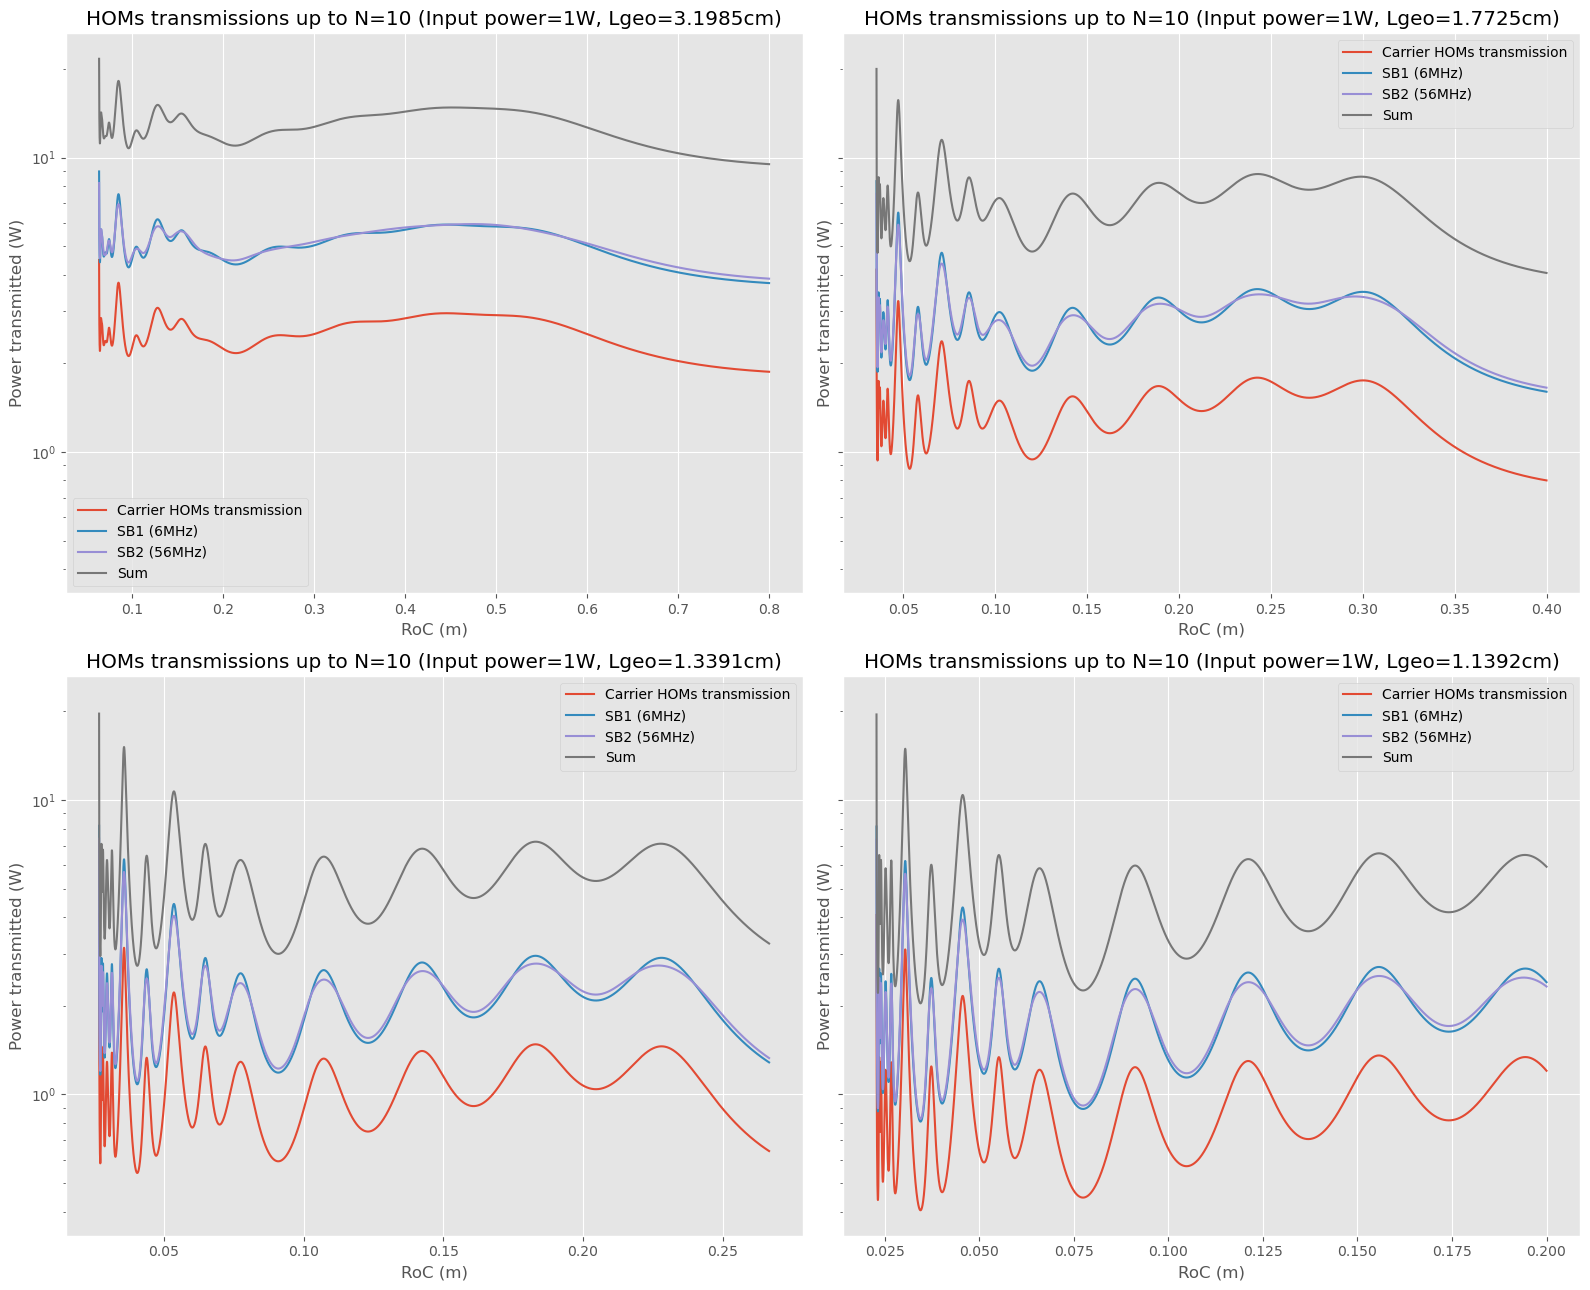

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 13), sharex=False, sharey=True)
axes = axes.flatten()

for i, (rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB, T_HOMs_vect_sum, Lgeo) in enumerate(results):
    ax = axes[i]
    ax.plot(rho_vect, T_HOMs_vect_car, label='Carrier HOMs transmission')
    ax.plot(rho_vect, T_HOMs_vect_SB[0], label='SB1 (6MHz)')
    ax.plot(rho_vect, T_HOMs_vect_SB[1], label='SB2 (56MHz)')
    ax.plot(rho_vect, T_HOMs_vect_sum, label='Sum')
    ax.set_xlabel('RoC (m)')
    ax.set_ylabel('Power transmitted (W)')
    ax.set_yscale('log')
    ax.set_title(f'HOMs transmissions up to N=10 (Input power=1W, Lgeo={round((Lgeo)*1e2,4)}cm)')
    ax.legend()

plt.tight_layout()
plt.show()


The best RoC seems to be the one after the oscillations of the T_HOMs, due to the HOMs resonnance. With more HOMs we should get a different answer.

## Studies with a 1.55cm cavity

The best compromise seems to be 1.55cm. We should investigate more on this design, notably by taking a RoC around 10cm. We also need to specify a minimum feasable width of the cavity (15mm).

We need to take the input power of each HOMs to choose the best RoC.

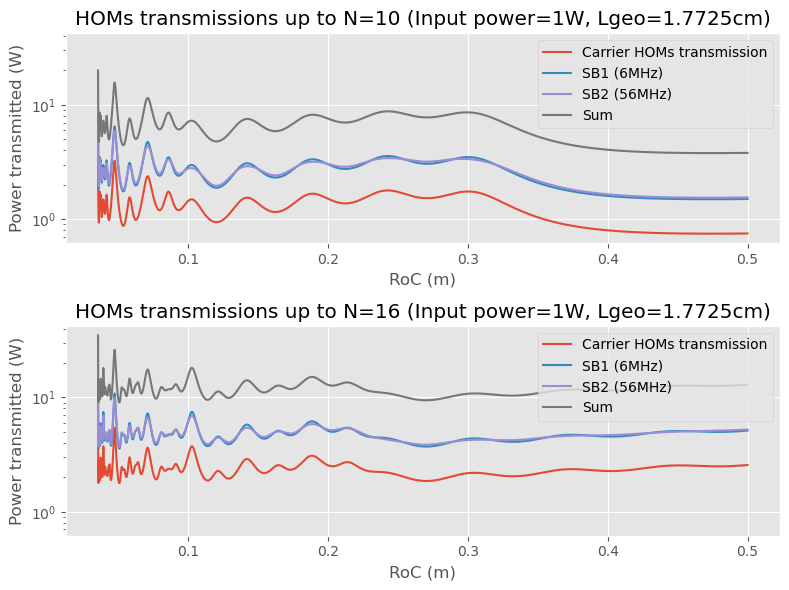

In [10]:
# Input parameters
nHOMs = [10, 16]

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=False, sharey=True)
axes = axes.flatten()

Lgeo = MCdf.Lgeo_cavity(0.061315/4, 0.026068)  # Geometric length of the cavity
Lopt = 2 * idxn * Lgeo  # Optical length travelled by the beam in the cavity

# Determine the max finesse that respect SB_limit
FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
Fomc = FLopt_max / Lopt

# Call the function with the input parameters
RoC_max = 0.5

for i, n in enumerate(nHOMs):
    P_HOMs = [np.ones(n), np.full(n, 2), np.full(n, 2)]  # Input power of carrier & SBs HOMs
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HOMs, 10001)

    # Calculate the total transmissions of the HOMs & the ideal RoC
    T_HOMs_vect_sum = T_HOMs_vect_car + T_HOMs_vect_SB[0] + T_HOMs_vect_SB[1]
    r = rho_vect[np.argmin(T_HOMs_vect_sum)]
    g = 1-Lgeo/r

    ax = axes[i]
    ax.plot(rho_vect, T_HOMs_vect_car, label='Carrier HOMs transmission')
    ax.plot(rho_vect, T_HOMs_vect_SB[0], label='SB1 (6MHz)')
    ax.plot(rho_vect, T_HOMs_vect_SB[1], label='SB2 (56MHz)')
    ax.plot(rho_vect, T_HOMs_vect_sum, label='Sum')
    ax.set_xlabel('RoC (m)')
    ax.set_ylabel('Power transmitted (W)')
    ax.set_yscale('log')
    ax.set_title(f'HOMs transmissions up to N={n} (Input power=1W, Lgeo={round((Lgeo)*1e2,4)}cm)')
    ax.legend()

plt.tight_layout()
plt.show()


In [11]:
P_HOMs = [np.ones(10), np.full(10, 2), np.full(10, 2)]  # Input power of carrier & SBs HOMs

In [12]:
# Characteristics & losses estimations

cavity_dim=[[0.061315/4],[15e-3]] # Fixed physical lengths & width of the cavity
Lgeo=MCdf.Lgeo_cavity(cavity_dim[0][0], cavity_dim[1][0]) # Compute the geometric length of the cavity
Lopt=2 * idxn * Lgeo

FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit)) # Determine the max finesse that respect SB_limit
Fomc=FLopt_max / Lopt

rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, 0.5, fm, P_HOMs, 10001) # Compute the best RoC
T_HOMs_vect_sum = T_HOMs_vect_car + T_HOMs_vect_SB[0] + T_HOMs_vect_SB[1]

# Extract the corresponding rho_vect and FoM_vect_sum values
indices = np.where((rho_vect >= 0.1) & (rho_vect <= 0.2))
rho_vect_filtered = rho_vect[indices]
T_HOMs_vect_sum_filtered = T_HOMs_vect_sum[indices]
min_index_filtered = np.argmin(T_HOMs_vect_sum_filtered) # Find the index of the minimum T_HOMs in the filtered T_HOMs_vect_sum
Ideal_RoC = rho_vect_filtered[min_index_filtered] # Get the corresponding rho value from the filtered rho_vect

print("Length (cm): physical=", cavity_dim[0][0]*1e2, ", Geometric=", Lgeo*1e2, ", Optical=", Lopt*1e2)
print("Finesse=", Fomc)
print("RoC (cm)=", Ideal_RoC*1e2)

Length (cm): physical= 1.532875 , Geometric= 1.619696804904582 , Optical= 4.695922158587658
Finesse= 9.426577402865988
RoC (cm)= 10.987626088663784


We also need to fix a length compatible with the resonnant conditions of the carrier.

In [13]:
Lgeo_interval=[Lgeo-1e-3, Lgeo+1e-3]

# Find resonnant length for the carrier transmission
resonnant_opt_lengths=MCdf.get_lengths(lambda_, Lgeo_interval, Ideal_RoC)
print("There is ", len(resonnant_opt_lengths), "resonnant lengths between geometric lengths (m) of ", Lgeo_interval[0], "and ", Lgeo_interval[1])

#Choose a length
resonnant_opt_length=MCdf.get_lengths(lambda_, Lgeo, Ideal_RoC)
Lgeo_reso=0.5*resonnant_opt_length/idxn

print("Resonnant geometric length (cm)=", Lgeo_reso*1e2)

There is  10900 resonnant lengths between geometric lengths (m) of  0.015196968049045818 and  0.01719696804904582
Resonnant geometric length (cm)= 1.6197043635492945


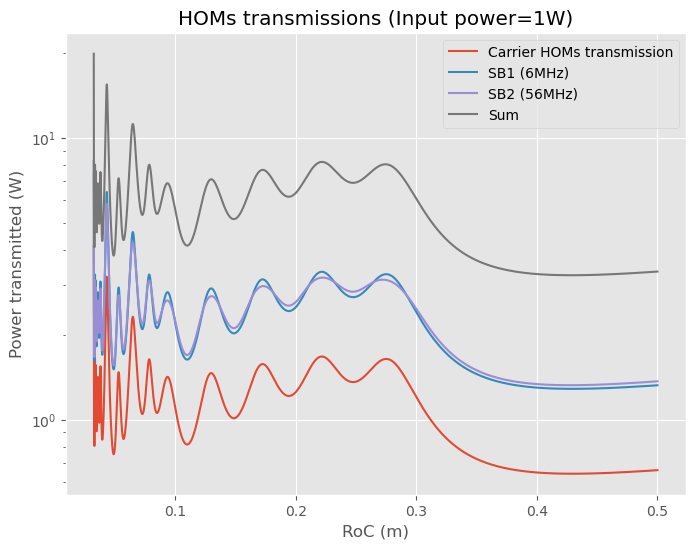

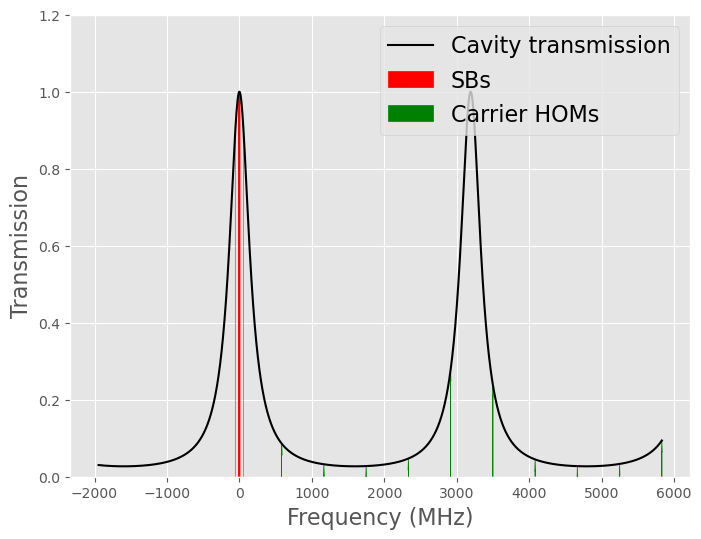

-----Transmissions-----
SBs transmissions: [0.9986301543548091, 0.9000925286913063]
HOMs transmissions: [1.0, 0.08607596997831027, 0.03231088996496391, 0.027626284528013738, 0.04723015715689072, 0.278239159018836, 0.2385878711910305, 0.044922783087956775, 0.027402782599396786, 0.03321805356208465, 0.0940845195845869]
df (MHz)= 1160.8336031094468


In [14]:
# First plot
plt.figure(figsize=(8, 6))
plt.plot(rho_vect, T_HOMs_vect_car, label='Carrier HOMs transmission')
plt.plot(rho_vect, T_HOMs_vect_SB[0], label='SB1 (6MHz)')
plt.plot(rho_vect, T_HOMs_vect_SB[1], label='SB2 (56MHz)')
plt.plot(rho_vect, T_HOMs_vect_sum, label='Sum')
plt.xlabel('RoC (m)')
plt.ylabel('Power transmitted (W)')
plt.yscale('log')
plt.title('HOMs transmissions (Input power=1W)')
plt.legend()
plt.show()

# Second plot
plt.figure(figsize=(8, 6))
MCdf.plot_transmission(Lgeo, Fomc, Ideal_RoC, fm, 10, plt.gca())
plt.show()

# Transmissions
g=1-(Lgeo/Ideal_RoC)
T = [MCdf.Trans_factor(Lgeo, Fomc, Ideal_RoC, freq, 0) for freq in fm] # of the SBs
TEM = [MCdf.Trans_factor(Lgeo, Fomc, Ideal_RoC, 0, N) for N in range(nm_max + 1)] # of the HOMs
df = np.arccos(np.sqrt(g)) * c / (2 * np.pi * Lgeo) # frequency difference between HOMs (due to the Gouy phase) Lgeo ou Lopt?

print("-----Transmissions-----")
print("SBs transmissions:",T)
print("HOMs transmissions:",TEM)
print("df (MHz)=", df/1e6)


In [15]:
# Cavity characteristics

T_HOMs = T_HOMs_vect_sum_filtered[min_index_filtered] # Get the minimum T_HOMs from the filtered T_HOMs_vect_sum
Mirror_angle=MCdf.mirror_angle(cavity_dim[0][0], cavity_dim[1][0]) # Compute the mirrors angle in radian
astigmatism_losses=MCdf.astigmatism_losses(Mirror_angle, Ideal_RoC, Lgeo) * 1e6 # Calculate astigmatism losses
print("HOMs transmission (W)=", T_HOMs)
print("Mirror angle (°)=", np.rad2deg(Mirror_angle), ", losses (ppm)=", astigmatism_losses)

waist = MCdf.waist_size(Lgeo, Ideal_RoC, lambda_)
print("Waist size (μm):", waist*1e6)

P_input = 1.0  # Input power in Watts
max_pwr = MCdf.circ_power(P_input, waist)
print("Circ power (MW/m²):", max_pwr/1e6)


HOMs transmission (W)= 4.141918747449072
Mirror angle (°)= 13.035712753855183 , losses (ppm)= 1291.2878755711024
Waist size (μm): 339.88637646068173
Circ power (MW/m²): 8.656303710663153


We can specify the error bars for the manufacturer if we zoom around this value.

Progress: 100.00%
Calculation done.


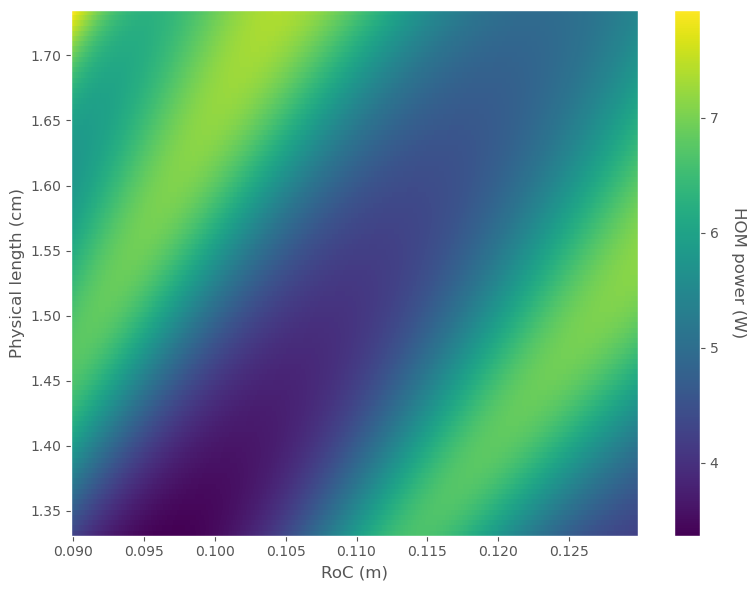

In [16]:
# Heatmap of the HOMs transmissions

# Create a grid of geometric lengths
Lphys_vect = np.linspace(cavity_dim[0][0]-0.002, cavity_dim[0][0]+0.002, 101) # cm

# Initialize T_HOMs matrices for carrier and SBs
T_HOMs_mat_car = np.zeros((len(Lphys_vect), 1001))
T_HOMs_mat_SB = np.zeros((len(Lphys_vect), 1001))

# Loop over geometric lengths and calculate T_HOMs
for j, Lphys in enumerate(Lphys_vect):
    Lgeo = MCdf.Lgeo_cavity(Lphys, 15e-3)  # Geometric length of the cavity
    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Lopt=2*idxn*Lgeo
    Fomc = FLopt_max / Lopt
    rho_vect, T_HOMs_vect_car, T_HOMs_vect_SB = MCdf.THOMvsRoC(Lgeo, Fomc, Ideal_RoC+0.02, fm, P_HOMs, 1001, Ideal_RoC-0.02)
    T_HOMs_mat_car[j, :] = T_HOMs_vect_car
    T_HOMs_mat_SB[j, :] = T_HOMs_vect_SB[0]+T_HOMs_vect_SB[1] # Transpose the result to match dimensions
    
    # Print percentage of completion
    sys.stdout.write("\rProgress: {0:.2f}%".format((j+1)/len(Lphys_vect)*100))
    sys.stdout.flush()

# After the loop
print("\nCalculation done.")

# Plot the heatmaps
plt.figure(figsize=(8, 6))

c1 = plt.pcolormesh(rho_vect, Lphys_vect*100, T_HOMs_mat_car+T_HOMs_mat_SB, cmap='viridis')
plt.xlabel('RoC (m)')
plt.ylabel('Physical length (cm)')
#plt.title('HOM power vs cavity RoC & geometric length with adapted finesse')
colorbar=plt.colorbar(c1)
colorbar.set_label('HOM power (W)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## Development for the Mode Cleaner OSCAR simulation

In [17]:
#Compute the focal length of a lens to get a wanted waist (not working for now)

print(MCdf.get_focal_length(339e-6, lambda_, 1, 0.049*2))

AttributeError: module 'MC_design_functions' has no attribute 'get_focal_length'